# **Лабораторная работа 5. Обучение и тестирование модели.**


# Установка библиотек


In [2]:
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Импорт датассета

In [4]:
from google.colab import files
data_to_load = files.upload()
dataset = files.upload()

Saving data.csv to data (1).csv


Saving dataset.zip to dataset.zip


In [39]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['data (1).csv']), delimiter=",")
from sklearn.utils import shuffle


def get_abs_path(row):
  return row['absolute path'].replace('D:\Coding\Python\python', '/content').replace("\\", "/")


df['absolute path'] = df.apply(get_abs_path, axis=1)
df = shuffle(df)
print(df.head(5))

                             absolute path class label  class  width  height  \
699   /content/dataset/brown_bear/0700.jpg  brown bear      0    238     180   
949   /content/dataset/brown_bear/0950.jpg  brown bear      0    170     203   
1727  /content/dataset/polar_bear/0716.jpg  polar bear      1    227     180   
1581  /content/dataset/polar_bear/0570.jpg  polar bear      1    276     180   
1282  /content/dataset/polar_bear/0271.jpg  polar bear      1    276     180   

      channels  
699          3  
949          3  
1727         3  
1581         3  
1282         3  


In [40]:
import zipfile
z = zipfile.ZipFile("/content/dataset.zip", 'r')
z.extractall()
print(os.listdir())

['.config', 'dataset', 'dataset.zip', 'data.csv', 'data (1).csv', 'sample_data']


# Проверка иображений

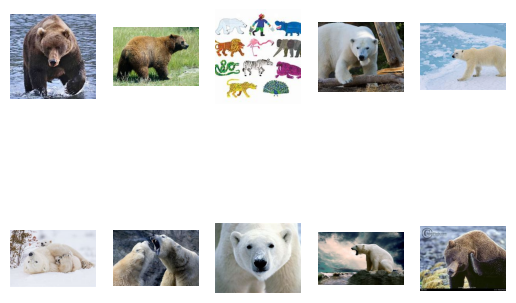

In [41]:
from matplotlib import pyplot as plt
img_list = df['absolute path'].tolist()
lbl_list = df['class'].tolist()
random_idx = np.random.randint(1,len(img_list),size=11)
figure = plt.figure()
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    img = Image.open(img_list[random_idx[i]])
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Разделение загруженного набора данных на обучающую, тестовую и валидационую выборки

In [42]:
X_train_list = img_list[0 : int(len(img_list) * 0.8)]
X_test_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
X_val_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))]

Y_train_list = lbl_list[0 : int(len(lbl_list) * 0.8)]
Y_test_list = lbl_list[int(len(lbl_list) * 0.8) : int(len(lbl_list) * 0.9)]
Y_val_list = lbl_list[int(len(lbl_list) * 0.9) : int(len(lbl_list))]
print(len(X_train_list ))
print(len(X_test_list))
print(len(X_val_list))

1627
203
204


# Класс для хранения загруженных и преобразованных изображений

In [43]:
class dataset(torch.utils.data.Dataset):

    def __init__(self,file_list, lbl_list,transform=None):
        self.file_list = file_list
        self.label_list = lbl_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = self.label_list[idx]
        return img_transformed,label

# Формирование набора данных

In [44]:
from torchvision import transforms
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(X_train_list, Y_train_list, transform=fixed_transforms)
test_data = dataset(X_test_list, Y_test_list, transform=fixed_transforms)
val_data = dataset(X_val_list, Y_val_list, transform=fixed_transforms)



# Проверка аугментации

1627


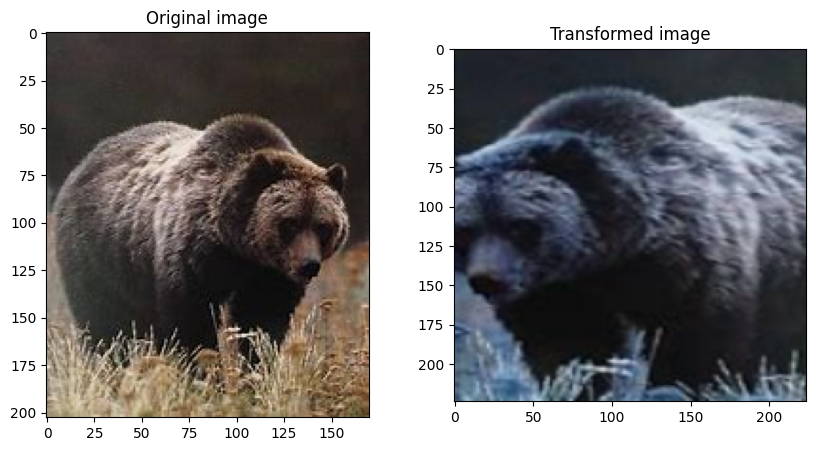

In [46]:
print(len(train_data))
train_data[0][0].shape
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(Image.open(img_list[1]))
plt.subplot(1, 2, 2)
plt.title('Transformed image')
plt.imshow(train_data[1][0].permute(1, 2, 0).numpy()[:, :, ::-1])

# Создании модели сверточной сети

In [433]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN,self).__init__()

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#             )

#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )


#         self.fc1 = nn.Linear(3*3*64,10)
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(10,2)
#         self.relu = nn.ReLU()


#     def forward(self,x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0),-1)
#         out = self.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 3 * 3, 32)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 2)  # 2 класса

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [434]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

model = CNN()
model.train()


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

# Функция для отрисовки графиков

In [49]:
def show_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="orange", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="steelblue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="steelblue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show()

# Train Loop

In [435]:
def train_loop(epochs, batch_size, lear):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lear)
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data,
                                            batch_size=batch_size,
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                            batch_size=batch_size,
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output,label)


                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item())
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

# Обучение модели с различными значениями параметров: batch_size (размер мини-пакетов) и learning rate (скорость обучения)


Epoch : 1, train accuracy : 0.8629411458969116, train loss : 0.35725992918014526
Epoch : 1, val_accuracy : 0.8600000143051147, val_loss : 0.4429742097854614
Epoch : 2, train accuracy : 0.934705913066864, train loss : 0.17571303248405457
Epoch : 2, val_accuracy : 0.8666666746139526, val_loss : 0.5098215937614441
Epoch : 3, train accuracy : 0.9259258508682251, train loss : 0.1846981942653656
Epoch : 3, val_accuracy : 0.7866666913032532, val_loss : 0.3848130702972412
Epoch : 4, train accuracy : 0.9397602677345276, train loss : 0.14921094477176666
Epoch : 4, val_accuracy : 0.8899999856948853, val_loss : 0.28661221265792847
Epoch : 5, train accuracy : 0.9588234424591064, train loss : 0.12201113253831863
Epoch : 5, val_accuracy : 0.8700000047683716, val_loss : 0.229622483253479
Epoch : 6, train accuracy : 0.9513506889343262, train loss : 0.12270837277173996
Epoch : 6, val_accuracy : 0.9533333778381348, val_loss : 0.12000805139541626
Epoch : 7, train accuracy : 0.9658822417259216, train loss 

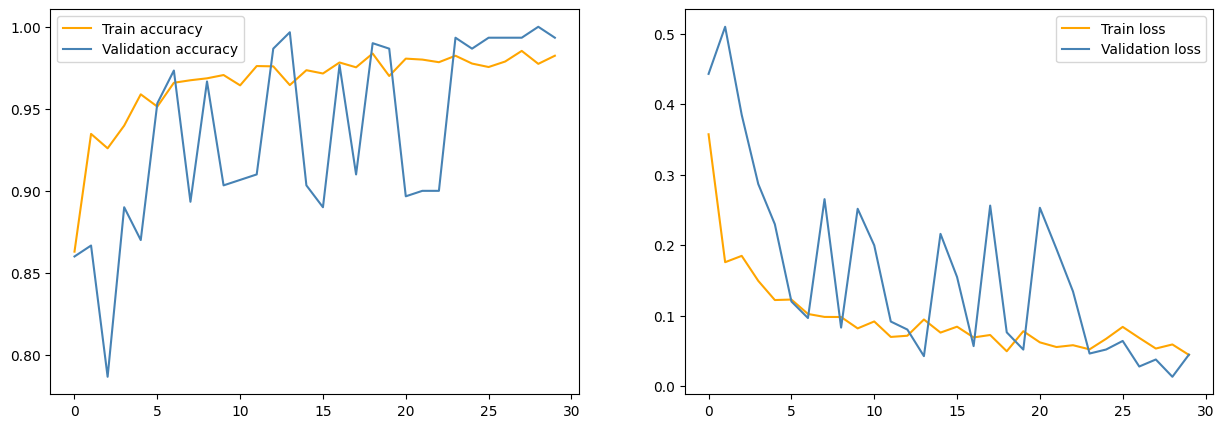

In [112]:
train_loop(30, 100, 0.001)

Epoch : 1, train accuracy : 0.8075308203697205, train loss : 0.47470909357070923
Epoch : 1, val_accuracy : 0.7074999809265137, val_loss : 0.6309237480163574
Epoch : 2, train accuracy : 0.9137653708457947, train loss : 0.25079092383384705
Epoch : 2, val_accuracy : 0.8424999713897705, val_loss : 0.4089530110359192
Epoch : 3, train accuracy : 0.934876561164856, train loss : 0.19629284739494324
Epoch : 3, val_accuracy : 0.8500000238418579, val_loss : 0.48100006580352783
Epoch : 4, train accuracy : 0.9275308847427368, train loss : 0.17687749862670898
Epoch : 4, val_accuracy : 0.8350000381469727, val_loss : 0.6291979551315308
Epoch : 5, train accuracy : 0.9516667127609253, train loss : 0.13274730741977692
Epoch : 5, val_accuracy : 0.8450000286102295, val_loss : 0.4206109046936035
Epoch : 6, train accuracy : 0.9473251700401306, train loss : 0.1418416053056717
Epoch : 6, val_accuracy : 0.8500000238418579, val_loss : 0.4411168694496155
Epoch : 7, train accuracy : 0.963888943195343, train loss :

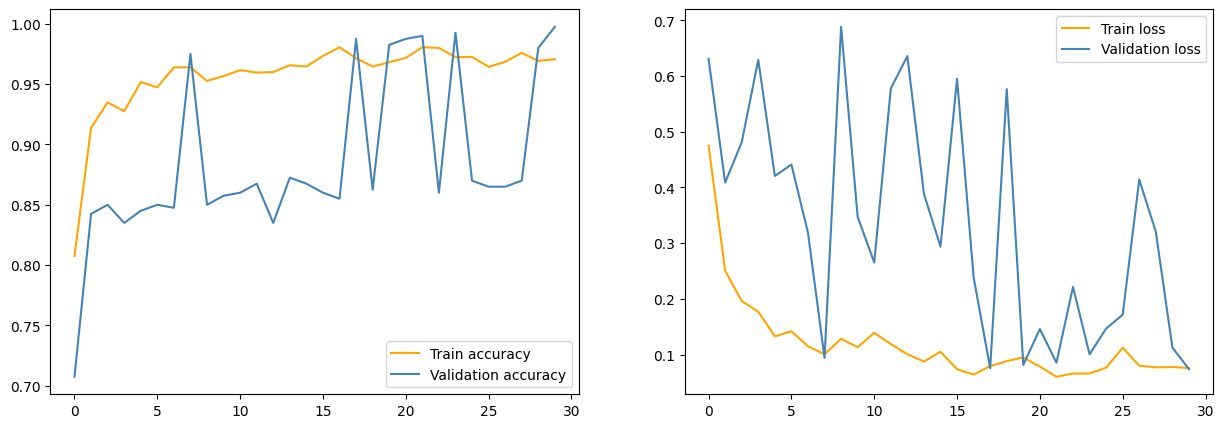

In [113]:
train_loop(30, 200, 0.001)

Epoch : 1, train accuracy : 0.5610324144363403, train loss : 0.6236941814422607
Epoch : 1, val_accuracy : 0.8872548937797546, val_loss : 0.46777889132499695
Epoch : 2, train accuracy : 0.8925371170043945, train loss : 0.38909852504730225
Epoch : 2, val_accuracy : 0.906862735748291, val_loss : 0.2953222990036011
Epoch : 3, train accuracy : 0.9224322438240051, train loss : 0.24075745046138763
Epoch : 3, val_accuracy : 0.9411764740943909, val_loss : 0.18547235429286957
Epoch : 4, train accuracy : 0.9458617568016052, train loss : 0.16919192671775818
Epoch : 4, val_accuracy : 0.9509803652763367, val_loss : 0.1657901108264923
Epoch : 5, train accuracy : 0.9461679458618164, train loss : 0.14848431944847107
Epoch : 5, val_accuracy : 0.9558823704719543, val_loss : 0.1333691030740738
Epoch : 6, train accuracy : 0.9607086181640625, train loss : 0.12292644381523132
Epoch : 6, val_accuracy : 0.9460784196853638, val_loss : 0.13892918825149536
Epoch : 7, train accuracy : 0.9571741223335266, train los

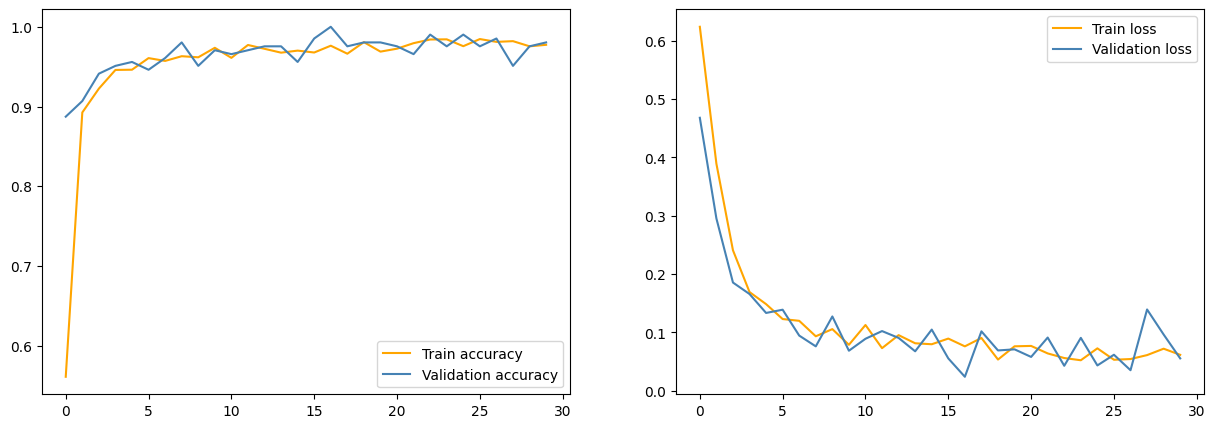

In [114]:
train_loop(30, 300, 0.001)

Epoch : 1, train accuracy : 0.8332897424697876, train loss : 0.47662553191185
Epoch : 1, val_accuracy : 0.8533333539962769, val_loss : 0.39282768964767456
Epoch : 2, train accuracy : 0.9225272536277771, train loss : 0.3748123049736023
Epoch : 2, val_accuracy : 0.8899999856948853, val_loss : 0.35186246037483215
Epoch : 3, train accuracy : 0.9364705681800842, train loss : 0.33441057801246643
Epoch : 3, val_accuracy : 0.9566667079925537, val_loss : 0.3031843304634094
Epoch : 4, train accuracy : 0.9397602677345276, train loss : 0.3025844395160675
Epoch : 4, val_accuracy : 0.8799999952316284, val_loss : 0.3083133101463318
Epoch : 5, train accuracy : 0.9450543522834778, train loss : 0.27521759271621704
Epoch : 5, val_accuracy : 0.8666666746139526, val_loss : 0.3269538879394531
Epoch : 6, train accuracy : 0.9358822703361511, train loss : 0.27652573585510254
Epoch : 6, val_accuracy : 0.9566667079925537, val_loss : 0.2503599226474762
Epoch : 7, train accuracy : 0.9501742124557495, train loss : 

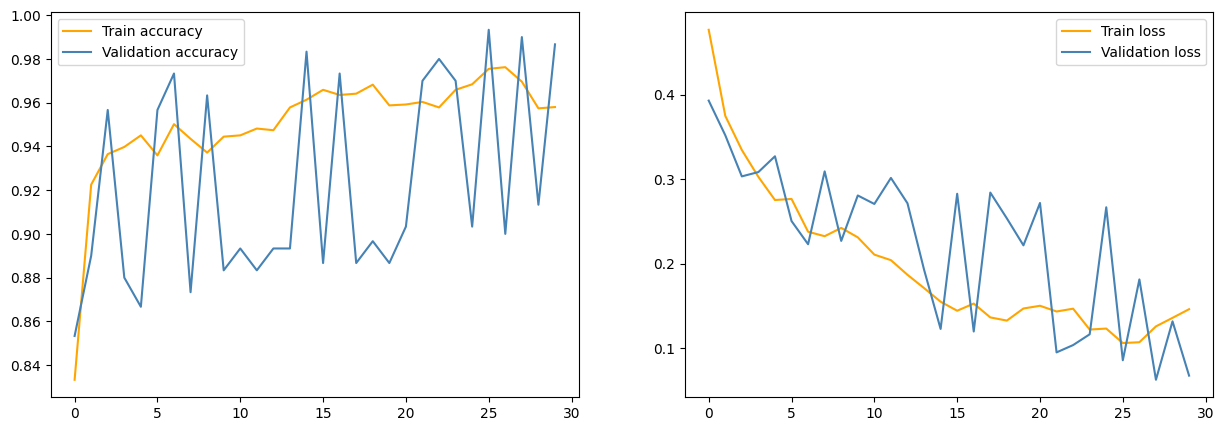

In [115]:
train_loop(30, 100, 0.005)

Epoch : 1, train accuracy : 0.8597736358642578, train loss : 0.35398486256599426
Epoch : 1, val_accuracy : 0.7024999856948853, val_loss : 0.668386697769165
Epoch : 2, train accuracy : 0.9245473742485046, train loss : 0.21149542927742004
Epoch : 2, val_accuracy : 0.8374999761581421, val_loss : 0.8600361943244934
Epoch : 3, train accuracy : 0.9289917945861816, train loss : 0.18074604868888855
Epoch : 3, val_accuracy : 0.8450000286102295, val_loss : 0.514695405960083
Epoch : 4, train accuracy : 0.9389917850494385, train loss : 0.17195641994476318
Epoch : 4, val_accuracy : 0.8474999666213989, val_loss : 0.4420478641986847
Epoch : 5, train accuracy : 0.9097530841827393, train loss : 0.22719305753707886
Epoch : 5, val_accuracy : 0.8474999666213989, val_loss : 0.24299739301204681
Epoch : 6, train accuracy : 0.9472222328186035, train loss : 0.14631685614585876
Epoch : 6, val_accuracy : 0.8524999618530273, val_loss : 0.5841130018234253
Epoch : 7, train accuracy : 0.9488888382911682, train loss 

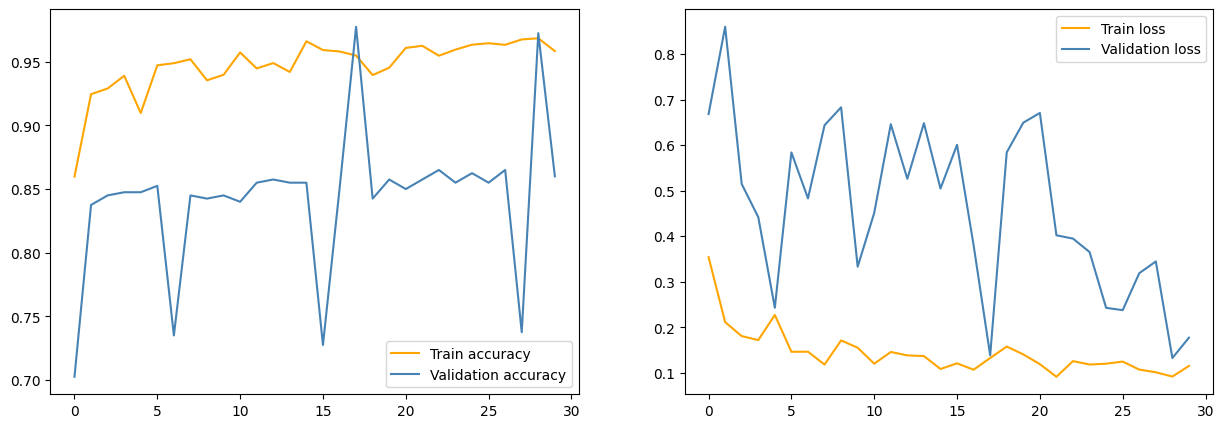

In [116]:
train_loop(30, 200, 0.005)

Epoch : 1, train accuracy : 0.7885432839393616, train loss : 0.4468637704849243
Epoch : 1, val_accuracy : 0.9215686321258545, val_loss : 0.18913210928440094
Epoch : 2, train accuracy : 0.9254593849182129, train loss : 0.1904938668012619
Epoch : 2, val_accuracy : 0.9460784196853638, val_loss : 0.14995664358139038
Epoch : 3, train accuracy : 0.9387444257736206, train loss : 0.15584228932857513
Epoch : 3, val_accuracy : 0.9607843160629272, val_loss : 0.12094589322805405
Epoch : 4, train accuracy : 0.9463692307472229, train loss : 0.1538897007703781
Epoch : 4, val_accuracy : 0.9215686321258545, val_loss : 0.3073204755783081
Epoch : 5, train accuracy : 0.9373359084129333, train loss : 0.1682908982038498
Epoch : 5, val_accuracy : 0.9313725233078003, val_loss : 0.179279625415802
Epoch : 6, train accuracy : 0.958083987236023, train loss : 0.1342783272266388
Epoch : 6, val_accuracy : 0.9607843160629272, val_loss : 0.11942797154188156
Epoch : 7, train accuracy : 0.9628828167915344, train loss : 

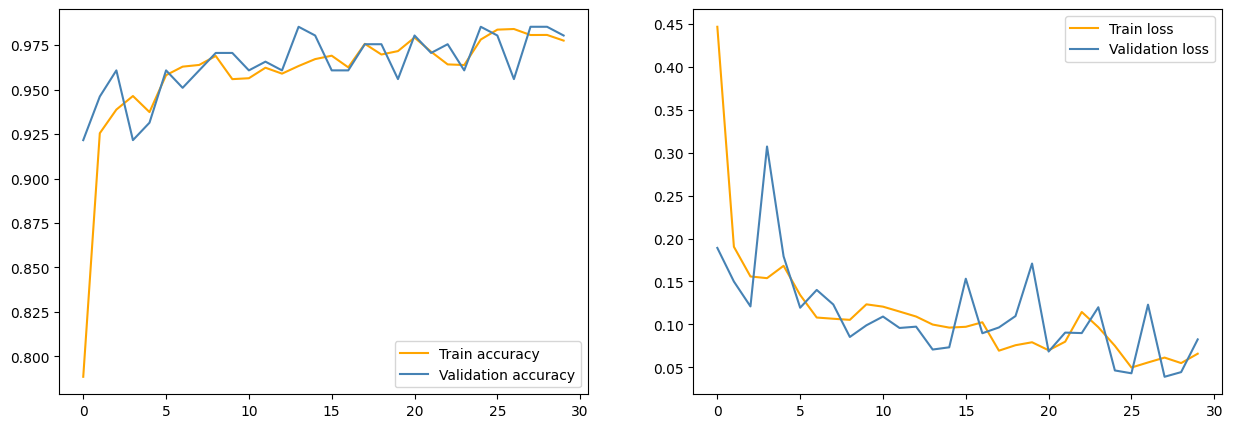

In [117]:
train_loop(30, 300, 0.005)

Epoch : 1, train accuracy : 0.855402946472168, train loss : 0.30810895562171936
Epoch : 1, val_accuracy : 0.84333336353302, val_loss : 0.46106165647506714
Epoch : 2, train accuracy : 0.9299998879432678, train loss : 0.1768045425415039
Epoch : 2, val_accuracy : 0.8566666841506958, val_loss : 0.4688712954521179
Epoch : 3, train accuracy : 0.9174073934555054, train loss : 0.2148875594139099
Epoch : 3, val_accuracy : 0.8666666746139526, val_loss : 0.3794125020503998
Epoch : 4, train accuracy : 0.9367537498474121, train loss : 0.16007588803768158
Epoch : 4, val_accuracy : 0.8733333349227905, val_loss : 0.35415494441986084
Epoch : 5, train accuracy : 0.9472330212593079, train loss : 0.14525315165519714
Epoch : 5, val_accuracy : 0.8766666650772095, val_loss : 0.54244464635849
Epoch : 6, train accuracy : 0.9409367442131042, train loss : 0.15452411770820618
Epoch : 6, val_accuracy : 0.9600000381469727, val_loss : 0.1172875463962555
Epoch : 7, train accuracy : 0.9550544023513794, train loss : 0.

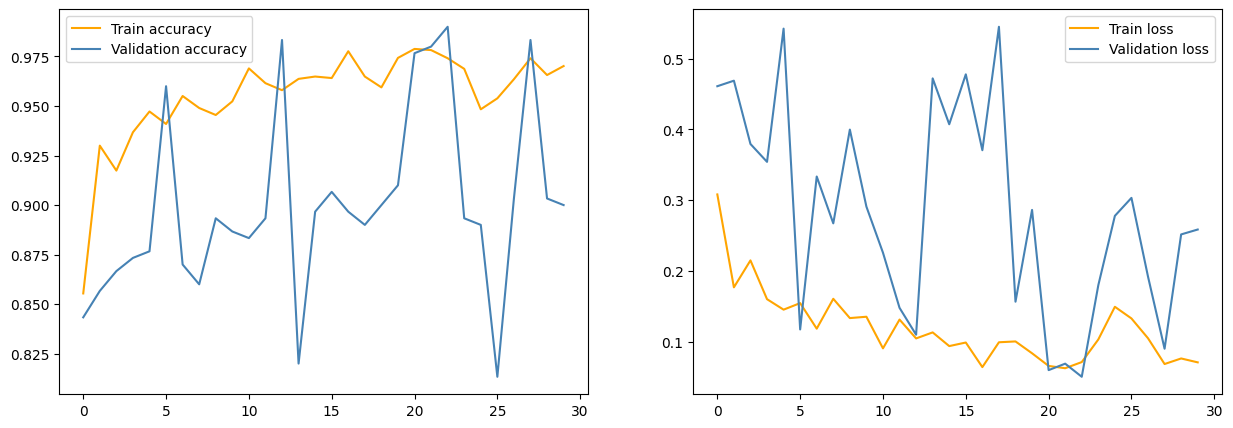

In [118]:
train_loop(30, 100, 0.007)


Epoch : 1, train accuracy : 0.8276543617248535, train loss : 0.3656303584575653
Epoch : 1, val_accuracy : 0.8274999856948853, val_loss : 0.6493191719055176
Epoch : 2, train accuracy : 0.9269958734512329, train loss : 0.1946009248495102
Epoch : 2, val_accuracy : 0.8350000381469727, val_loss : 0.5216155052185059
Epoch : 3, train accuracy : 0.9105349779129028, train loss : 0.22904512286186218
Epoch : 3, val_accuracy : 0.8474999666213989, val_loss : 0.46260979771614075
Epoch : 4, train accuracy : 0.9264403581619263, train loss : 0.2062852531671524
Epoch : 4, val_accuracy : 0.8574999570846558, val_loss : 0.2842628061771393
Epoch : 5, train accuracy : 0.9353291392326355, train loss : 0.1859453171491623
Epoch : 5, val_accuracy : 0.8474999666213989, val_loss : 0.6138039231300354
Epoch : 6, train accuracy : 0.9375514984130859, train loss : 0.1734621226787567
Epoch : 6, val_accuracy : 0.8550000190734863, val_loss : 0.6730508804321289
Epoch : 7, train accuracy : 0.9399999976158142, train loss : 0

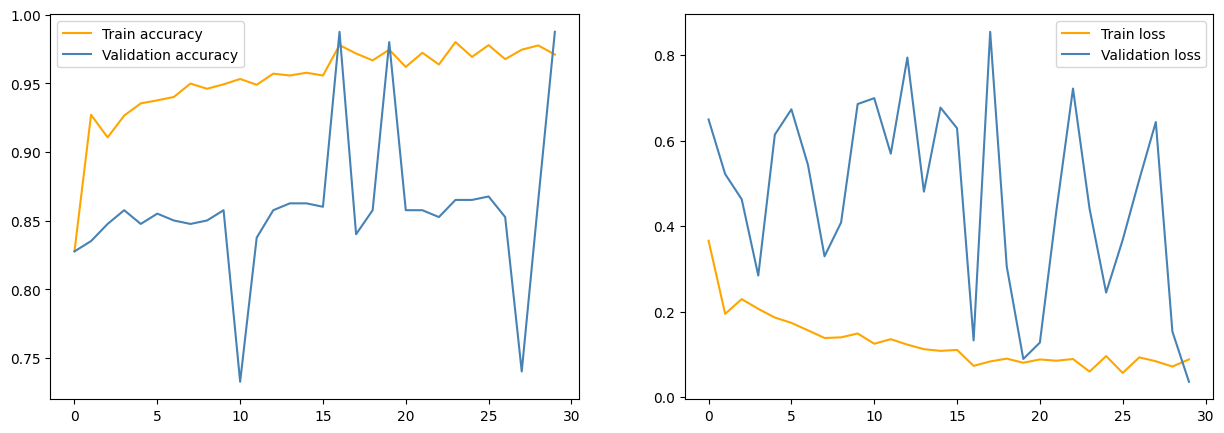

In [119]:
train_loop(30, 200, 0.007)

Epoch : 1, train accuracy : 0.8528346419334412, train loss : 0.34258270263671875
Epoch : 1, val_accuracy : 0.8872548937797546, val_loss : 0.23955270648002625
Epoch : 2, train accuracy : 0.9084951877593994, train loss : 0.22157259285449982
Epoch : 2, val_accuracy : 0.9215686321258545, val_loss : 0.21661628782749176
Epoch : 3, train accuracy : 0.9214742183685303, train loss : 0.20303964614868164
Epoch : 3, val_accuracy : 0.9656862616539001, val_loss : 0.10118742287158966
Epoch : 4, train accuracy : 0.9313210844993591, train loss : 0.17017172276973724
Epoch : 4, val_accuracy : 0.9411764740943909, val_loss : 0.13770464062690735
Epoch : 5, train accuracy : 0.9281889200210571, train loss : 0.17746247351169586
Epoch : 5, val_accuracy : 0.9117646813392639, val_loss : 0.2099427431821823
Epoch : 6, train accuracy : 0.9447025656700134, train loss : 0.1473514586687088
Epoch : 6, val_accuracy : 0.9460784196853638, val_loss : 0.12533795833587646
Epoch : 7, train accuracy : 0.9445013403892517, train 

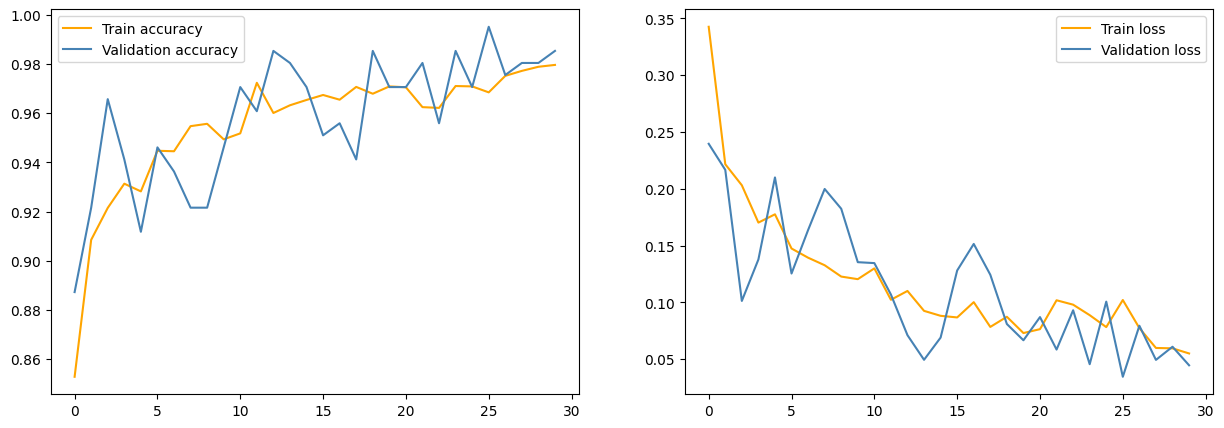

In [120]:
train_loop(30, 300, 0.007)

В ходе ряда проведенных экспериментов, была выявлена тенденция: при достижении моделью точности на тренировочной выборке свыше ~0.93, точность на валидационной выборке заметно снижалась, а значение ошибки возрастало. Этот феномен наблюдался вне зависимости от различий в параметрах архитектуры модели сверточной нейронной сети. Ввиду чего можно выдвинуть гипотезу: Вероятность
~0.93 классификации непереобученной моделью образа в соответсвующий ему класс - является, вероятно, глобальным максимумом при обучении модели на текущем наборе данных. Причиной может служить большое количество "мусорных" изображений не соответсвующих ни одному классу, в наборе данных, на котором происходило обучение модели. При попытке модели "адаптироваться" к классификации таких изображений, модель корректирует веса так, чтоб обобщить сильно отличающиеся признаки таких изображений от общих признаков изображений на которых она была обучена раннее, тем самым теряя способность выявлять отличительные признаки и увеличивая вероятность активации нейронов ответственных за выявление характерных признаков изображений того или иного класса.

В экспериментах с обучением модели с различными значениями параметров: batch_size (размер мини-пакетов) и learning rate (скорость обучения) были выявлены следующие наиболее оптимальные параметры обучения:

*   **batch_size = 300**
  При таком размере мини-пакетов, которые подаются модели на каждой итерации цикла обучения, результирующие графики показывают наименьшую корреляцию в поведении показателей на обучающей и валидационной выборках.
*   **learning rate = 0.01** При такой скорости обучения, результирующие графики показывают сходимость результатов к более высоким значениям.



Epoch : 1, train accuracy : 0.5044488310813904, train loss : 0.6892166137695312
Epoch : 1, val_accuracy : 0.5539215803146362, val_loss : 0.6753222346305847
Epoch : 2, train accuracy : 0.6987051963806152, train loss : 0.6601769924163818
Epoch : 2, val_accuracy : 0.75, val_loss : 0.6195273995399475
Epoch : 3, train accuracy : 0.8118284940719604, train loss : 0.5806500911712646
Epoch : 3, val_accuracy : 0.8725489974021912, val_loss : 0.46659889817237854
Epoch : 4, train accuracy : 0.8454200029373169, train loss : 0.4330424666404724
Epoch : 4, val_accuracy : 0.8235294222831726, val_loss : 0.360266774892807
Epoch : 5, train accuracy : 0.844663143157959, train loss : 0.364889532327652
Epoch : 5, val_accuracy : 0.8627451062202454, val_loss : 0.31011828780174255
Epoch : 6, train accuracy : 0.8814742565155029, train loss : 0.3151552975177765
Epoch : 6, val_accuracy : 0.9019607901573181, val_loss : 0.2796422243118286
Epoch : 7, train accuracy : 0.8901618123054504, train loss : 0.2916884124279022

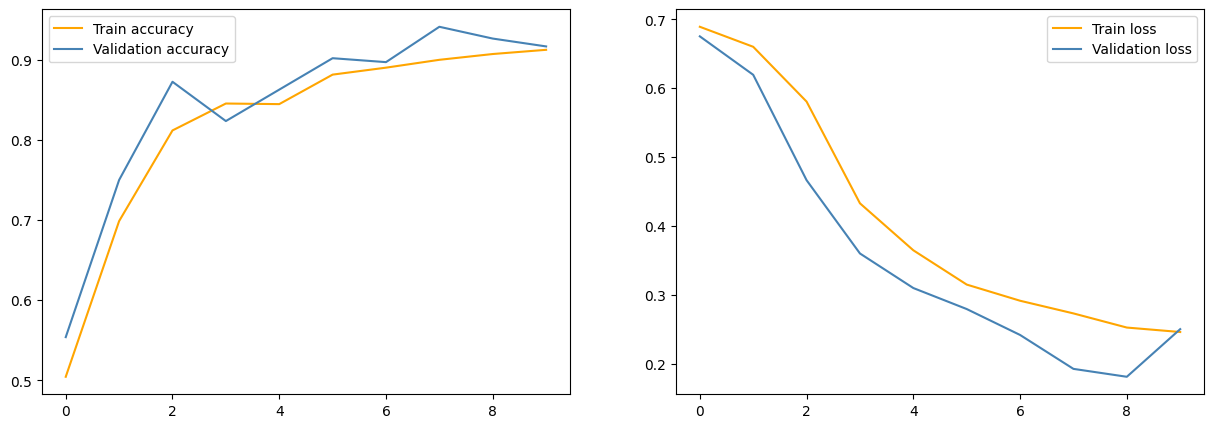

In [436]:
train_loop(10, 300, 0.001)

Однако проверка модели на тестовых данных, показала что лучше всего снизить количество эпох.

# Сохранение полученных результатов

In [437]:
bears_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size=300,
                                          shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        bears_probs += list(zip(list(fileid), preds_list))
bears_probs.sort(key = lambda x : int(x[0]))
bears_probs[:10]

[(tensor(0), 0.7365041375160217),
 (tensor(0), 0.05289852246642113),
 (tensor(0), 0.00023773498833179474),
 (tensor(0), 2.74385243415054e-08),
 (tensor(0), 0.0002886394504457712),
 (tensor(0), 0.001281916513107717),
 (tensor(0), 0.20494355261325836),
 (tensor(0), 0.00042784569086506963),
 (tensor(0), 0.15938562154769897),
 (tensor(0), 0.5893653631210327)]

In [438]:
idx = list(i for i in range(len(bears_probs)))
prob = list(map(lambda x: x[1],bears_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,0,7.365041e-01
1,1,5.289852e-02
2,2,2.377350e-04
3,3,2.743852e-08
4,4,2.886395e-04
...,...,...
198,198,9.152393e-01
199,199,9.670691e-01
200,200,9.149991e-01
201,201,7.252589e-01


# Сохранение обученной модели

In [439]:
torch.save(model.state_dict(), os.path.join("/content", "weight.pt"))

# Запуск модели на тестовых данных

In [440]:
mymodel = CNN()
mymodel.load_state_dict(torch.load(os.path.join("/content", "weight.pt")))

<All keys matched successfully>

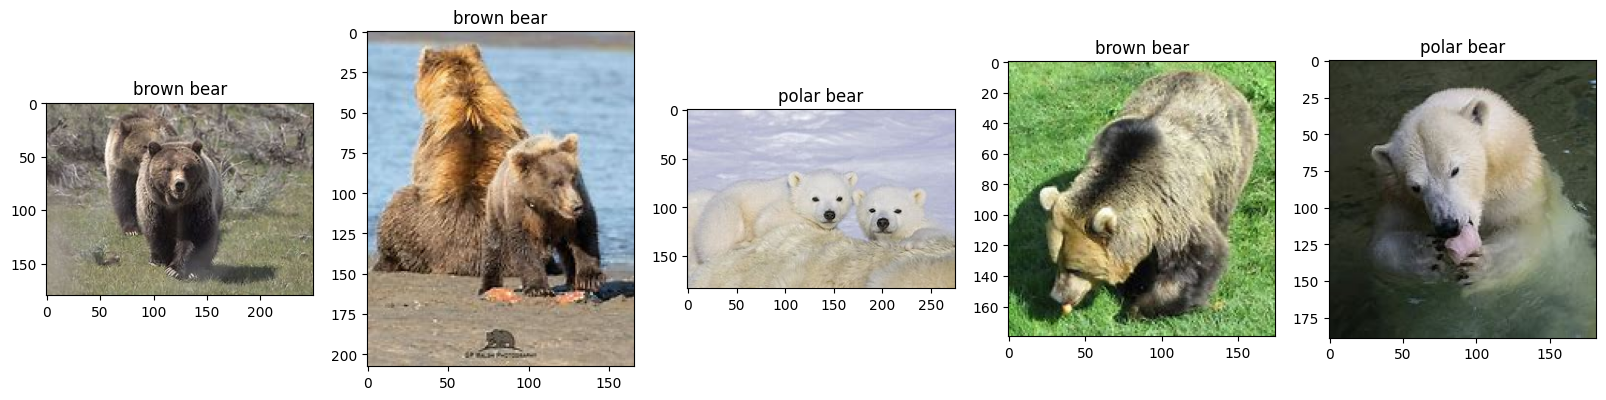

In [444]:
id_list = []
class_ = {0: 'brown bear', 1: 'polar bear'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = X_test_list[i]
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)